In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

from QLSTM import SequenceDataset

import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import scienceplots

# plt.style.use(['science','ieee'])
plt.rcParams['axes.grid'] = True
# no use latex
plt.rcParams['text.usetex'] = False

In [24]:
df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')

In [25]:
columns = ["Close"]

In [26]:
data = df.filter(columns)
dataset = data.values

In [27]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [28]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

In [29]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [30]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [31]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 1])
Target shape: torch.Size([1])


In [32]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [33]:
from QLSTM import ShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 7

model = ShallowRegressionLSTM(
    num_sensors=len(features),
    hidden_units=num_hidden_units,
    num_layers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
# Count number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 288


In [35]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
# test_loss = test_model(test_loader, model, loss_function)
print()

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------

Epoch 0
---------
Train loss: 0.02109941460859058
Test loss: 0.005053616644406283
Epoch 1
---------
Train loss: 0.003029144573927334
Test loss: 0.0025364699772214444
Epoch 2
---------
Train loss: 0.0018104220084234968
Test loss: 0.001431144073403495
Epoch 3
---------
Train loss: 0.0007256599452745149
Test loss: 0.00033755231160214586
Epoch 4
---------
Train loss: 0.0002445658958499384
Test loss: 0.00011370159447481554
Epoch 5
---------
Train loss: 4.596808175447466e-05
Test loss: 4.658250544202418e-05
Epoch 6
---------
Train loss: 2.168292385049548e-05
Test loss: 2.7431996854463286e-05
Epoch 7
---------
Train loss: 2.701252251571061e-05
Test loss: 2.5474070803151828e-05
Epoch 8
---------
Train loss: 2.0050363407914265e-05
Test loss: 6.281506867161486e-05
Epoch 9
---------
Train loss: 3.664419845202462e-05
Test loss: 6.107094503274437e-05
Epoch 10
---------
Train loss: 2.5180219202976926e-05
Test loss: 1.5572163465605333e-05
Epoch 11
---------
Train loss: 3.7374

In [36]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, model).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, model).numpy()

In [37]:
# plt.figure(figsize=(12, 7))
# plt.plot(range(len(df_train)), df_train[columns], label = "Real")
# plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "LSTM Train Prediction")
# plt.ylabel('Stock Price')
# plt.xlabel('Days')
# plt.legend()
# plt.show()

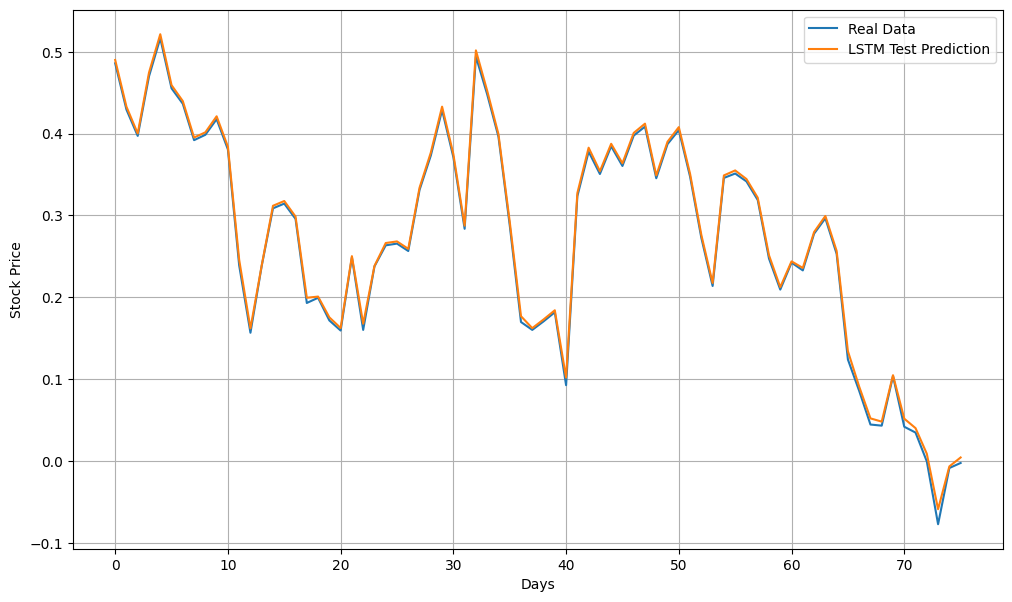

In [38]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test[columns], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "LSTM Test Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

In [39]:
# df_test.to_csv('AAPL_2022-01-01_2023-01-01_LSTM.csv', index=False)

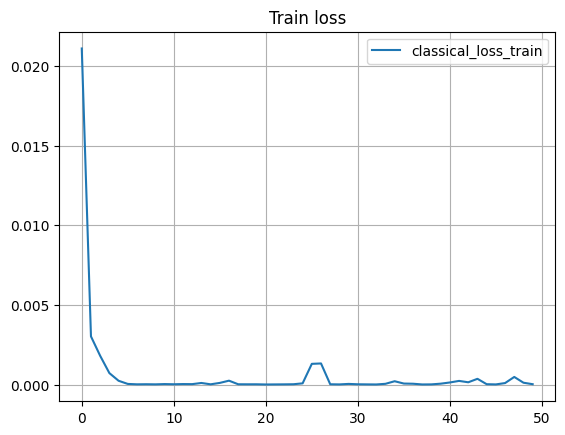

In [43]:
plt.plot(classical_loss_train, label='classical_loss_train')
# plt.plot(classical_loss_test, label='classical_loss_test')
pd.DataFrame(classical_loss_train).to_csv('LSTM_loss.csv', index=False)
plt.title('Train loss')
plt.legend()

In [41]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train[columns], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test[columns], df_test["Model Forecast"]))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.00455284125187847
Test RMSE: 0.004867907186596113


In [42]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["Close"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close"], df_test["Model Forecast"])
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 1.0
Test accuracy: 1.0
